# Similarity Modeling 1/2: Recognizing Pigs with Deep Learning

## Student
Gallus Huber (51905700)

## Timesheet
2022-10-16 09:00 - 12:30 SIM 1 & 2 <br />
2022-10-16 15:00 - 17:00 SIM 3 <br />
2022-10-18 10:00 - 13:00 SIM 4 & 5 <br />
2022-10-27 20:00 - 22:00 SIM 6 <br />
2022-10-28 10:00 - 14:00 SIM 7 & 8 & 9 <br />
2022-11-02 08:00 - 14:00 Writing abstracts <br />
2022-11-10 14:00 - 15:00 Meeting <br />
2022-11-24 16:00 - 17:30 Setup <br />
2022-11-26 09:00 - 12:00 Implementation data preparation <br />
2022-11-27 10:00 - 10:30 Meeting <br />
2022-11-27 10:30 - 15:00 Implementation model <br />
2022-12-01 16:00 - 20:00 Training of model <br />
2022-12-03 14:00 - 18:00 Improvements

## Required libraries and installs

In [3]:
!cat requirements-dl-video.txt
!pip install -r requirements-dl-video.txt

pandas
numpy
opencv-python
matplotlib
scikit-learn
scikit-image
tensorflow
keras
visualkerasLooking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 33.3 MB/s 


## Imports

In [13]:
import os
import glob
import pathlib
import collections

import pandas as pd
import numpy as np

import cv2 as cv2
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
import skimage.transform as trans

import tensorflow as tf

import keras.applications as appl
import keras.models as models
import keras.layers as layers
import keras.utils as utils
import keras.callbacks as cb
import keras.optimizers as optimizers

import visualkeras

## Constants

In [15]:
# path to ground truth and videos
DATA_PATH = "/content/drive/MyDrive/data/"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")

# path to train data
TRAINING_PATH = os.path.join(VIDEO_PATH, 'training_data')
VALIDATION_PATH = os.path.join(VIDEO_PATH, 'validation_data')
TESTING_PATH = os.path.join(VIDEO_PATH, 'testing_data')

# path to save and load trained models
MODEL_PATH = "/content/drive/MyDrive/data/models"

# Project structure

In [16]:
# create dirs for training
train_path_0 = os.path.join(TRAINING_PATH, '0')
train_path_1 = os.path.join(TRAINING_PATH, '1')

# create dirs for validation
valid_path_0 = os.path.join(VALIDATION_PATH, '0')
valid_path_1 = os.path.join(VALIDATION_PATH, '1')

# create dirs for testing
test_path_0 = os.path.join(TESTING_PATH, '0')
test_path_1 = os.path.join(TESTING_PATH, '1')

In [17]:
# create dirs for training
if not os.path.exists(TRAINING_PATH):
    os.makedirs(TRAINING_PATH)
if not os.path.exists(train_path_0):
    os.makedirs(train_path_0)
if not os.path.exists(train_path_1):
    os.makedirs(train_path_1)

# create dirs for validation
if not os.path.exists(VALIDATION_PATH):
    os.makedirs(VALIDATION_PATH)
if not os.path.exists(valid_path_0):
    os.makedirs(valid_path_0)
if not os.path.exists(valid_path_1):
    os.makedirs(valid_path_1)

# create dirs for testing
if not os.path.exists(TESTING_PATH):
    os.makedirs(TESTING_PATH)
if not os.path.exists(test_path_0):
    os.makedirs(test_path_0)
if not os.path.exists(test_path_1):
    os.makedirs(test_path_1)

# create dir for models
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

# 1. Data Preparation

## 1.1 List all videos

In [18]:
videos = glob.glob(VIDEO_PATH + '/*.avi')

videos_tmp = []
for video in videos:
    videos_tmp.append(pathlib.Path(video).name)
videos = videos_tmp

videos

['Muppets-02-01-01.avi', 'Muppets-02-04-04.avi', 'Muppets-03-04-03.avi']

## 1.2 Load ground truth

### 1.2.1 Read ground truth from CSV

In [19]:
ground_truth = dict()

# read in corresponding ground truth
for video in videos:
        file_name = glob.glob(GROUND_TRUTH_PATH + '/*' + os.path.splitext(video)[0] + '*.csv')
        csv = pd.read_csv(os.path.join(file_name[0]), sep=";")
        ground_truth[video] = csv

### 1.2.2 Plot the ground truth

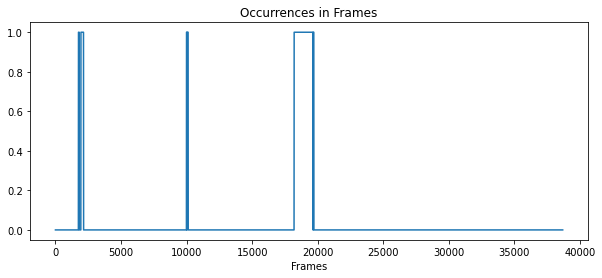

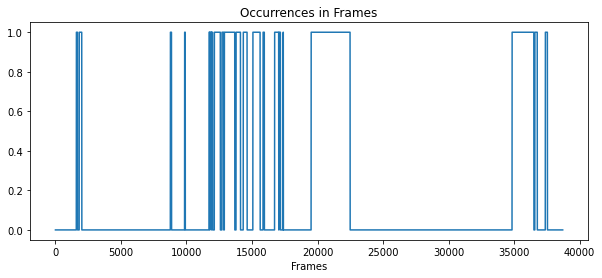

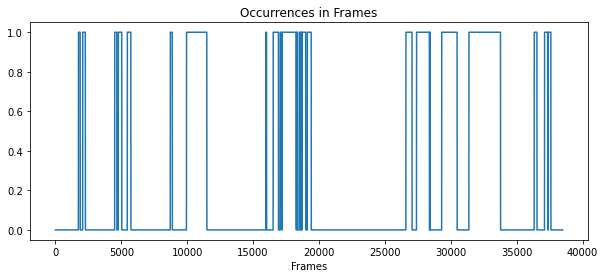

In [20]:
def plot_gt(gt, column):
    plot = plt.figure(figsize=(10, 4))

    # define subplot
    subplot = plot.add_subplot(111)
    subplot.set_title(f"Occurrences in Frames")

    # define x axis
    subplot.set_xlabel('Frames')

    # mark occurrences
    frame_indicator = np.zeros(len(gt['Frame_number']))
    frame_indicator[gt[gt[column] == 1].index] = 1

    subplot.plot(gt[column].index, frame_indicator)
    plt.show()

for video in videos:
    plot_gt(ground_truth[video], "Pigs")

## 1.3 Load video data

### 1.3.1 Data structure to store splits

In [21]:
train_data = dict()
valid_data = dict()
test_data = dict()

### 1.3.2 Create splits
The ground truth is split into training set, validation set and testing set.

In [22]:
for video in videos:
    train_data[video], test_data[video] = ms.train_test_split(ground_truth[video], test_size=0.2, shuffle=True, random_state=42)
    train_data[video], valid_data[video] = ms.train_test_split(train_data[video], test_size=0.25, random_state=42)

### 1.3.3 Get frames of video
The frames are written to the corresponding directory based on the splits and ground truth.

In [23]:
def retrieve_frames(video_file):
    # open a videoCap for this video
    video_cap = cv2.VideoCapture(os.path.join(VIDEO_PATH, video_file))

    # used to identify frame in ground truth
    frame_nr = 0

    # read all frames of video
    while True:
        # get one frame
        success_read, frame_read = video_cap.read()

        # no more frames available
        if not success_read:
            break

        # create filename
        filename = 'frame_%d.jpg' % frame_nr

        # write frames to dir
        if frame_nr in train_data[video_file].Frame_number:
            if (train_data[video_file][train_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(train_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(train_path_1, filename), frame_read)

        elif frame_nr in valid_data[video_file].Frame_number:
            if (valid_data[video_file][valid_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(valid_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(valid_path_1, filename), frame_read)

        elif frame_nr in test_data[video_file].Frame_number:
            if (test_data[video_file][test_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(test_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(test_path_1, filename), frame_read)

        # go to next frame
        frame_nr += 1


for video in videos:
    retrieve_frames(video)
    print(f"Loaded frames of {video} successfully")

Loaded frames of Muppets-02-01-01.avi successfully
Loaded frames of Muppets-02-04-04.avi successfully
Loaded frames of Muppets-03-04-03.avi successfully


# 2 Model

## 2.1 Build model

### 2.1.1 Create the model

In [117]:
# create base model -> pretrained model
base_model = appl.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add base model
head_model = base_model.output

# additional hidden layer
head_model = layers.Flatten()(head_model)
head_model = layers.Dense(units=512,activation="relu")(head_model)
head_model = layers.Dense(units=256,activation="relu")(head_model)
# create output layer
head_model = layers.Dense(1, activation="softmax")(head_model)

# create model
model = models.Model(base_model.input, head_model)

# base model should not be trained
for layer in base_model.layers:
	layer.trainable = False

model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

### 2.1.2 Plot the model


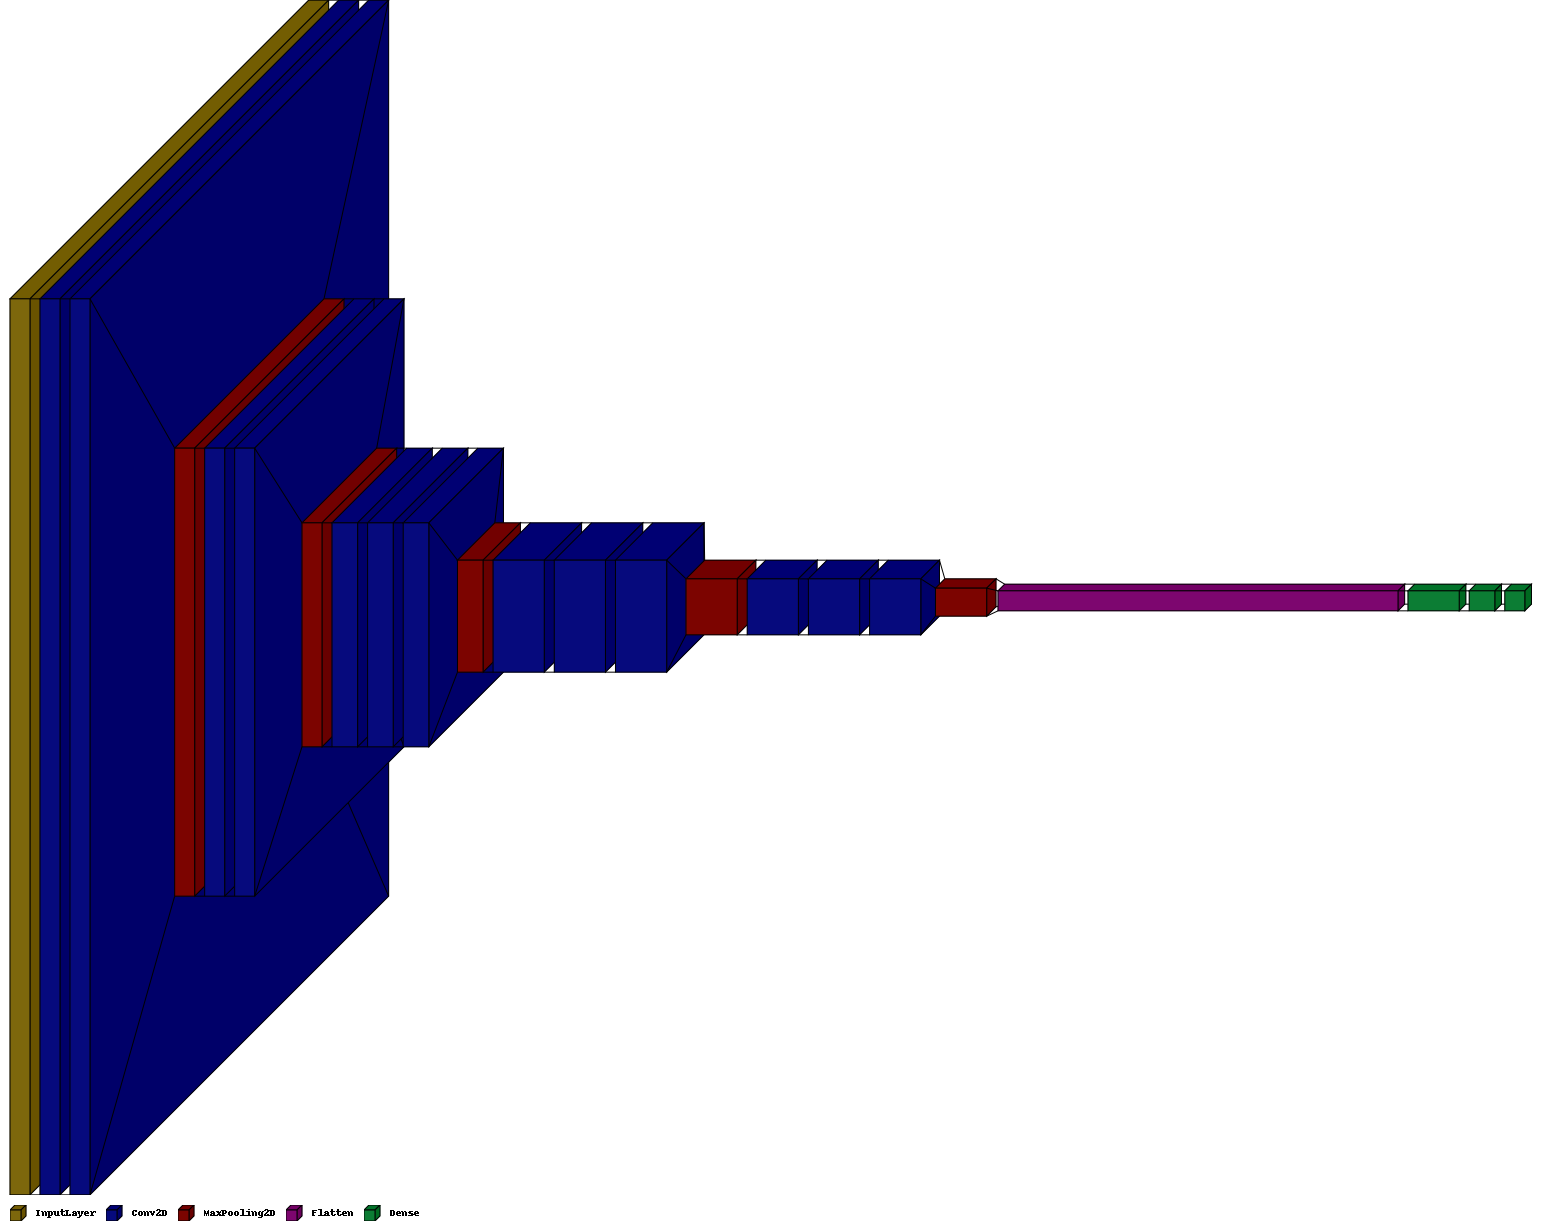

In [118]:
# set colors for each used layer
color_map = collections.defaultdict(dict)
color_map[layers.InputLayer]['fill'] = '#7D670C'
color_map[layers.Conv2D]['fill'] = '#060A7D'
color_map[layers.MaxPooling2D]['fill'] = '#7C0400'
color_map[layers.Flatten]['fill'] = '#7D066F'
color_map[layers.Dense]['fill'] = '#0C7D34'
color_map[layers.Dropout]['fill'] = '#808080'

# plot the model
visualkeras.layered_view(model, legend=True, color_map=color_map)

## 2.2 Compile model

In [119]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9, decay=0.01), metrics=['accuracy'])

## 2.3 Train model

### 2.3.1 Train model

In [ ]:
# load training set
train_ds = utils.image_dataset_from_directory(
    directory=TRAINING_PATH,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

# load validation set
validation_ds = utils.image_dataset_from_directory(
    directory=VALIDATION_PATH,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

# callback to avoid overfitting and storing best model
callbacks = [cb.EarlyStopping(monitor='val_accuracy', patience=5),
             cb.ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'best_model.h5'), monitor='val_accuracy', save_best_only=True)]

# train model
with tf.device('/device:GPU:0'):
  history = model.fit(train_ds, epochs=25, validation_data=validation_ds, callbacks=callbacks)

Found 44094 files belonging to 2 classes.
Found 19859 files belonging to 2 classes.
Epoch 1/25
1378/1378 [==============================] - 425s 307ms/step - loss: nan - accuracy: 0.7208 - val_loss: nan - val_accuracy: 0.7843
Epoch 2/25
1378/1378 [==============================] - 437s 316ms/step - loss: nan - accuracy: 0.7267 - val_loss: nan - val_accuracy: 0.7843
Epoch 3/25
1378/1378 [==============================] - 364s 262ms/step - loss: nan - accuracy: 0.7267 - val_loss: nan - val_accuracy: 0.7843
Epoch 4/25
1378/1378 [==============================] - 358s 259ms/step - loss: nan - accuracy: 0.7267 - val_loss: nan - val_accuracy: 0.7843
Epoch 5/25
 169/1378 [==>...........................] - ETA: 3:58 - loss: nan - accuracy: 0.7167

### 2.3.3 Plot training results

In [ ]:
metrics = history.history
plt.plot(metrics["accuracy"])
plt.plot(metrics['val_accuracy'])

plt.title("Model Accuracy")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.legend(["Accuracy","Validation Accuracy"])

plt.show()

# 3 Results

## 3.1 Load best model

In [ ]:
model = models.load_model(os.path.join(MODEL_PATH, 'best_model.h5'))

## 3.2 Evaluate model

In [ ]:
# load testing set
test_ds = utils.image_dataset_from_directory(
    directory=TESTING_PATH,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

# evaluate the model
results = model.evaluate(test_ds, batch_size=128)

results

## 3.3 Prediction for videos

In [55]:
video_prediction = dict()

for video in videos:
    video_prediction[video] = []

In [ ]:
for video in videos:
    # open videoCap for video
    video_capture = cv2.VideoCapture(os.path.join(VIDEO_PATH, video))

    # read all frames of video
    while True:
        # get one frame
        success, frame = video_capture.read()

        # identify frame
        frame_number = 0

        # no more frames available
        if not success:
            break

        # reshape frame to fit to input layer
        frame = trans.resize(frame, output_shape=(224, 224))
        frame = np.reshape(frame,[1, 224, 224, 3])

        # use model to make prediction for frame
        prediction = model.predict(frame)
        video_prediction[video].append((frame_number, prediction))

video_prediction